In [1]:
import zarr
from cellpose import models, core
from tqdm.auto import tqdm
import numpy as np
import glob
from natsort import natsorted
import re
import os
from pathlib import Path

import torch
from trackastra.model import Trackastra
from trackastra.tracking import graph_to_ctc, graph_to_napari_tracks
from trackastra.data import example_data_bacteria




Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




/home/dayn/miniconda3/envs/godspeed/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load a pretrained model
trackastra_model = Trackastra.from_pretrained("ctc", device=device)

import torch
    
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available.")

cellpose_model = models.CellposeModel(gpu=True)
anisotropy = None
Mtb_load_thresh = None

INFO:trackastra.model.model:Loading model state from /home/dayn/.trackastra/.models/ctc/model.pt


/home/dayn/.trackastra/.models/ctc already downloaded, skipping.


/home/dayn/miniconda3/envs/godspeed/lib/python3.10/site-packages/trackastra/model/model.py:498: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(fpath, map_l

GPU is available!
Device name: NVIDIA RTX A6000


INFO:cellpose.models:>>>> loading model /home/dayn/.cellpose/models/cpsam


In [3]:
base_dir = Path('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1')#

In [4]:
zarr_dirs = natsorted((base_dir / "acquisition/zarr").glob("*"))
zarr_dirs

[PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(3, 3).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(3, 4).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(3, 5).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(3, 6).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(3, 7).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(3, 8).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measurement 1/acquisition/zarr/(4, 4).zarr'),
 PosixPath('/mnt/DATA3/BPP0050/BPP0050-1-Live-cell-to4i_Live-2__2025-04-10T18_45_48-Measur

In [5]:
import sys

# Get a dictionary of all variables in the current scope
all_vars = globals().copy()

# Remove built-in variables and some special ones
to_exclude = ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__']
vars_to_check = {k: v for k, v in all_vars.items() if not k.startswith('_') and k not in to_exclude}

# Function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

# Get the size of each variable
var_sizes = [(k, get_size(v)) for k, v in vars_to_check.items()]

# Sort by size in descending order
sorted_vars = sorted(var_sizes, key=lambda item: item[1], reverse=True)

# Print the largest variables
print("Largest variables in memory:")
for name, size in sorted_vars[:10]:  # Display the top 10 largest
    print(f"{name}: {size / (1024 * 1024):.2f} MB")

Largest variables in memory:
tqdm: 0.00 MB
Trackastra: 0.00 MB
Path: 0.00 MB
Out: 0.00 MB
zarr_dirs: 0.00 MB
open: 0.00 MB
natsorted: 0.00 MB
graph_to_ctc: 0.00 MB
graph_to_napari_tracks: 0.00 MB
example_data_bacteria: 0.00 MB


### Trialling new output

In [6]:
from ast import literal_eval

In [7]:
for zarr_dir in tqdm(zarr_dirs):
    acq_ID = literal_eval(zarr_dir.stem) 
    label_dir = f'{base_dir}/labels/{acq_ID}/'
    
    os.makedirs(label_dir, exist_ok=True)
    
    zarr_group = zarr.open_group(zarr_dir)
    
    bf = zarr_group.images[:,-1,...].max(axis=1)
    dpc = zarr_group.images[:,0,...].max(axis=1)
    
    segmentation_input = np.stack([bf, dpc], axis=1)
    del bf
    del dpc
    
    segmentation = []
    for i, segmentation_input_frame in tqdm(enumerate(segmentation_input), total = len(segmentation_input), leave=False):
        masks, flows, styles = cellpose_model.eval(segmentation_input_frame, 
                                          diameter=100,
                                         )
        segmentation.append(masks)
    segmentation = np.stack(segmentation, axis=0)
    
    # Track the cells
    track_graph = trackastra_model.track(segmentation_input[:,0], segmentation, mode="greedy_nodiv") 
    
    # Write to cell tracking challenge format
    ctc_tracks, masks_tracked = graph_to_ctc(
          track_graph,
          segmentation,
          outdir=os.path.join(label_dir, 'trackastra'),
    )
    
    # napari_tracks, napari_tracks_graph, _ = graph_to_napari_tracks(track_graph)

    # try:
    #     compressor = Blosc(cname="zstd", clevel=5, shuffle=Blosc.BITSHUFFLE)
    #     store = zarr.DirectoryStore(zarr_dir)
    #     root = zarr.group(store=store)
        
    #     # --- 1. Save raw segmentation
    #     root.require_group("labels")
    #     root["labels"].create_dataset(
    #         "raw",
    #         data=segmentation,
    #         chunks=(1,) + segmentation.shape[1:],
    #         compressor=compressor,
    #         dtype="uint16",
    #         overwrite=True
    #     )
        
    #     root["labels"].create_dataset(
    #         "tracked",
    #         data=masks_tracked,
    #         chunks=(1,) + masks_tracked.shape[1:],
    #         compressor=compressor,
    #         dtype="uint16",
    #         overwrite=True
    #     )
        
    #     # Write .zattrs for both
    #     for label_name in ["raw", "tracked"]:
    #         label_path = Path(zarr_dir) / "labels" / label_name / ".zattrs"
    #         label_meta = {
    #             "image-label": {
    #                 "version": "0.4",
    #                 "source": "../images",
    #                 "labels": {
    #                     "0": {
    #                         "name": label_name,
    #                         "description": f"{label_name} segmentation masks"
    #                     }
    #                 }
    #             }
    #         }
    #         with open(label_path, "w") as f:
    #             json.dump(label_meta, f, indent=2)
        
    #     # --- 2. Save napari-style tracks table
    #     track_table_dir = Path(zarr_dir) / "tables" / "tracks"
    #     track_table_dir.mkdir(parents=True, exist_ok=True)
        
    #     # Save each column of napari_tracks df
    #     for col in napari_tracks.columns:
    #         data = napari_tracks[col].to_numpy()
    #         zarr.save(track_table_dir / col, data)
        
    #     # Write .zattrs
    #     track_zattrs = {
    #         "table": {
    #             "columns": [{"name": col, "type": "float32" if napari_tracks[col].dtype.kind == 'f' else "int"} for col in napari_tracks.columns],
    #             "region": "image",
    #             "type": "track",
    #             "version": "0.4"
    #         }
    #     }
    #     with open(track_table_dir / ".zattrs", "w") as f:
    #         json.dump(track_zattrs, f, indent=2)
        
    #     # --- 3. Optionally save napari_tracks_graph
    #     if napari_tracks_graph is not None:
    #         graph_dir = Path(zarr_dir) / "tables" / "graph"
    #         graph_dir.mkdir(parents=True, exist_ok=True)
        
    #         for col in napari_tracks_graph.columns:
    #             data = napari_tracks_graph[col].to_numpy()
    #             zarr.save(graph_dir / col, data)
        
    #         graph_zattrs = {
    #             "table": {
    #                 "columns": [{"name": col, "type": "int"} for col in napari_tracks_graph.columns],
    #                 "region": "track",
    #                 "type": "track_edges",
    #                 "version": "0.4"
    #             }
    #         }
    #         with open(graph_dir / ".zattrs", "w") as f:
    #             json.dump(graph_zattrs, f, indent=2)

    # except:
    #     print('woops')

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [24:08<00:00, 10.06s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 4005.80it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [03:10<00:00,  1.35s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1624 edges in frame 142  Total edges: 278640:  99%|█████████▉| 143/144 [03:31<00:01,  1.35s/it]
                                                                                               INFO:trackastra.tracking.tracking:Added 250998 vertices, 278640 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [23:00<00:00,  9.59s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 2589.82it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [02:46<00:00,  1.18s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1571 edges in frame 142  Total edges: 245543:  99%|█████████▉| 143/144 [02:57<00:01,  1.20s/it]
                                                                                               INFO:trackastra.tracking.tracking:Added 227819 vertices, 245543 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [23:23<00:00,  9.75s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 3425.96it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [02:27<00:00,  1.04s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1375 edges in frame 142  Total edges: 236822:  99%|█████████▉| 143/144 [02:47<00:00,  1.16it/s]
                                                                                               INFO:trackastra.tracking.tracking:Added 220923 vertices, 236822 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [24:40<00:00, 10.28s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 2143.94it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [03:42<00:00,  1.58s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1686 edges in frame 142  Total edges: 291271:  99%|█████████▉| 143/144 [04:03<00:01,  1.76s/it]
                                                                                               INFO:trackastra.tracking.tracking:Added 267638 vertices, 291271 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [22:16<00:00,  9.28s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 3482.12it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [02:08<00:00,  1.10it/s]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1266 edges in frame 142  Total edges: 216043:  99%|█████████▉| 143/144 [02:31<00:00,  1.08it/s]
                                                                                               INFO:trackastra.tracking.tracking:Added 206384 vertices, 216043 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [23:22<00:00,  9.74s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 3255.14it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [03:05<00:00,  1.32s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1605 edges in frame 142  Total edges: 269494:  99%|█████████▉| 143/144 [03:28<00:01,  1.33s/it]
                                                                                               INFO:trackastra.tracking.tracking:Added 245662 vertices, 269494 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [23:07<00:00,  9.63s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 2719.44it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [02:32<00:00,  1.08s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1361 edges in frame 142  Total edges: 231567:  99%|█████████▉| 143/144 [02:49<00:00,  1.01it/s]
                                                                                               INFO:trackastra.tracking.tracking:Added 215590 vertices, 231567 edges
INFO:track

  0%|          | 0/144 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 144 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|███████████████████████████████████| 144/144 [24:36<00:00, 10.26s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|████████████████████████████████████| 141/141 [00:00<00:00, 2237.03it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|████████████████████████████████| 141/141 [02:59<00:00,  1.27s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1

1486 edges in frame 142  Total edges: 267510:  99%|█████████▉| 143/144 [03:23<00:01,  1.15s/it]
                                                                                               INFO:trackastra.tracking.tracking:Added 237419 vertices, 267510 edges
INFO:track

# Previous method

In [10]:
for zarr_dir in tqdm(zarr_dirs):
    acq_ID = tuple(map(int, re.search(r'\((\d+),\s*(\d+)\)', zarr_dir).groups()))
    label_dir = f'{base_dir}/labels/{acq_ID}/'
    os.makedirs(label_dir, exist_ok=True)
    
    zarr_group = zarr.open_group(zarr_dir)
    
    bf = zarr_group.images[:,-1,...].max(axis=1)
    dpc = zarr_group.images[:,0,...].max(axis=1)
    
    segmentation_input = np.stack([bf, dpc], axis=1)
    del bf
    del dpc
    
    segmentation = []
    for i, segmentation_input_frame in tqdm(enumerate(segmentation_input), total = len(segmentation_input), leave=False):
        masks, flows, styles = cellpose_model.eval(segmentation_input_frame, 
                                          diameter=100,
                                         )
        segmentation.append(masks)
    segmentation = np.stack(segmentation, axis=0)
    
    # Track the cells
    track_graph = trackastra_model.track(segmentation_input[:,0], segmentation, mode="greedy_nodiv")  # or mode="ilp", or "greedy_nodiv"
    
    # Write to cell tracking challenge format
    ctc_tracks, masks_tracked = graph_to_ctc(
          track_graph,
          segmentation,
          outdir=os.path.join(label_dir, 'trackastra'),
    )
    
    napari_tracks, napari_tracks_graph, _ = graph_to_napari_tracks(track_graph)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [08:44<00:00, 10.92s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 2802.72it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [01:04<00:00,  1.43s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [07:40<00:00,  9.60s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3771.48it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:49<00:00,  1.10s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [08:07<00:00, 10.16s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 2991.09it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [01:02<00:00,  1.40s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [07:49<00:00,  9.79s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3601.36it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:57<00:00,  1.28s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [07:44<00:00,  9.69s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3651.17it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:50<00:00,  1.12s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [09:05<00:00, 11.37s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1890.88it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [01:17<00:00,  1.71s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [08:08<00:00, 10.18s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3462.17it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:52<00:00,  1.17s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [09:01<00:00, 11.28s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3047.50it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [01:16<00:00,  1.70s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [08:29<00:00, 10.61s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 2062.80it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:59<00:00,  1.33s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [08:53<00:00, 11.12s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1951.50it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [01:10<00:00,  1.58s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [07:31<00:00,  9.40s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3299.31it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:42<00:00,  1.06it/s]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


  0%|          | 0/48 [00:00<?, ?it/s]

INFO:trackastra.model.model_api:Predicting weights for candidate graph
INFO:trackastra.data.wrfeat:Extracting features from 48 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction

Extracting features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [07:52<00:00,  9.85s/it]
INFO:trackastra.model.model_api:Building windows

Building windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 3057.52it/s]
INFO:trackastra.model.model_api:Predicting windows

Computing associations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:55<00:00,  1.23s/it]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1


In [25]:
import napari

In [26]:
viewer = napari.Viewer(title = '4i live cell')

In [27]:
segmentation_input.shape

(144, 2, 6911, 6911)

In [28]:
masks_tracked.shape

(144, 6911, 6911)

In [29]:
viewer.add_image(segmentation_input, channel_axis=1)
viewer.add_labels(masks_tracked)

<Labels layer 'masks_tracked' at 0x7f9d14437010>

In [30]:
from skimage import measure

In [31]:
measure.label(masks_tracked[0]).max()

1369

In [32]:
(masks_tracked[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [26]:
viewer.camera.zoom = 0.13

In [29]:
track_graph

In [33]:
napari_tracks, napari_tracks_graph, _ = graph_to_napari_tracks(track_graph)

100%|█████████████████████████████████████████████████████████████████████████| 14781/14781 [00:01<00:00, 10134.78it/s]


In [34]:
viewer.add_tracks(napari_tracks)

<Tracks layer 'napari_tracks' at 0x7f9ded043640>

In [52]:
for layer in viewer.layers:
    layer.scale = [10,1,1] 

In [36]:
import pandas as pd

In [37]:
tracks = pd.DataFrame(napari_tracks, columns=['ID', 't', 'y', 'x'])

In [44]:
napari_tracks

array([[1.00000000e+00, 1.42000000e+02, 3.53727905e+03, 3.35564697e+03],
       [1.00000000e+00, 1.43000000e+02, 3.53097290e+03, 3.36449097e+03],
       [2.00000000e+00, 1.42000000e+02, 6.14485107e+03, 3.14998120e+03],
       ...,
       [1.47810000e+04, 1.41000000e+02, 4.53262695e+03, 5.33093994e+03],
       [1.47810000e+04, 1.42000000e+02, 4.55470215e+03, 5.33497119e+03],
       [1.47810000e+04, 1.43000000e+02, 4.53238525e+03, 5.34296777e+03]])

In [45]:
tracks

,ID,t,y,x
0,1.0,142.0,3537.279053,3355.646973
1,1.0,143.0,3530.972900,3364.490967
2,2.0,142.0,6144.851074,3149.981201
3,2.0,143.0,6146.757812,3148.761475
4,3.0,134.0,105.832069,1052.947510
...,...,...,...,...
214106,14781.0,139.0,4545.214355,5324.233887
214107,14781.0,140.0,4535.510254,5324.465332
214108,14781.0,141.0,4532.626953,5330.939941
214109,14781.0,142.0,4554.702148,5334.971191


In [61]:
viewer.close()

In [46]:
import seaborn as sns

In [50]:
len(tracks.groupby('ID').filter(lambda x: len(x) > 100).ID.unique())

449

<Axes: ylabel='Count'>

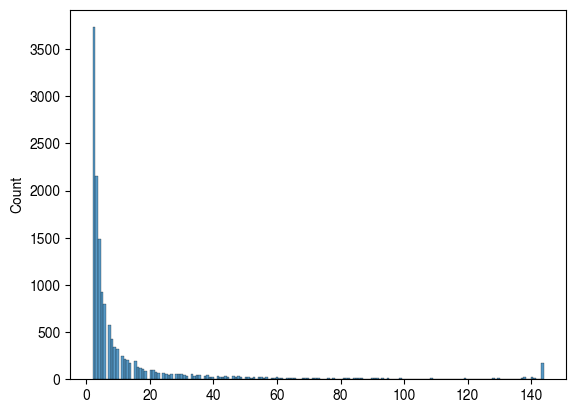

In [47]:
sns.histplot(tracks.groupby('ID').size())